In [1]:
from pathlib import Path
import pandas as pd

In [4]:
# Directorios
base_dir = Path().resolve()

# Rutas de CSVs
path_csv_hist = base_dir.parent / "franco" / "API-connect" / "posts_con_sentimiento_historia.csv"
path_csv_agrupado = base_dir.parent / "franco" / "API-connect" / "analisis_sentimiento_diario.csv"

In [5]:
# Lectura CSVs
df = pd.read_csv(path_csv_hist)
df_hist = df.copy()
df_diario = pd.read_csv(path_csv_agrupado)

In [6]:
df_hist.head()

,actor_handle,uri,text,created_at,likes,reposts,replies,text_length,word_count,hour,engagement,date,sentiment,sentiment_vader,interpretacion_sentimiento
0,mclem.org,at://did:plc:skf244z64dfa5yvynksq65ij/app.bsky...,The Executive Branch must cease its illegal im...,2025-04-16 12:27:53.844000+00:00,0,0,0,290,44,12,0,2025-04-16,-0.166667,-0.8020,Negativo
1,mclem.org,at://did:plc:skf244z64dfa5yvynksq65ij/app.bsky...,The US President who literally campaigned on a...,2025-04-16 12:27:53.843000+00:00,0,0,1,287,41,12,1,2025-04-16,0.000000,-0.8192,Negativo
2,bloomberg.com,at://did:plc:uewxgchsjy4kmtu7dcxa77us/app.bsky...,Harvard's $9 billion battle with Trump risks e...,2025-04-16 12:18:42.398000+00:00,15,4,3,124,17,12,22,2025-04-16,0.000000,-0.5719,Negativo
3,theguardian.com,at://did:plc:vovinwhtulbsx4mwfw26r5ni/app.bsky...,My parents holding hands after their assisted ...,2025-04-16 12:18:41.212000+00:00,110,10,3,94,13,12,123,2025-04-16,0.250000,0.0000,Neutral
4,theguardian.com,at://did:plc:vovinwhtulbsx4mwfw26r5ni/app.bsky...,Doge unemployment ‘fraud’ discoveries are old ...,2025-04-16 12:06:49.417000+00:00,140,54,6,79,12,12,200,2025-04-16,0.100000,-0.4404,Negativo


In [7]:
df_diario.head()

,date,sentimiento_promedio,interpretacion
0,2024-01-01,0.157135,Positivo
1,2024-01-02,0.112922,Positivo
2,2024-01-03,0.075192,Positivo
3,2024-01-04,0.112786,Positivo
4,2024-01-05,0.051773,Positivo


In [8]:
# Transformaciones
df_diario = df_diario.rename(columns={"date": "fecha", "interpretacion": "interpretacion_promedio"})

df_diario['fecha'] = pd.to_datetime(df_diario['fecha'], utc=True, errors='coerce')
df_hist['created_at'] = pd.to_datetime(df['created_at'], utc=True, errors='coerce')


# recorto horarios
df_diario['fecha'] = df_diario['fecha'].dt.date
df_hist['fecha'] = df_hist['created_at'].dt.date

In [9]:
# Genero df con fechas agrupadas
df_resumen = (
    df_hist.groupby('fecha')
      .agg(
          interpretacion_moda = ('interpretacion_sentimiento', lambda x: x.mode().iloc[0]),
          frecuencia = ('interpretacion_sentimiento', lambda x: x.value_counts().iloc[0])
      )
      .reset_index()
)

df_resumen.head()

,fecha,interpretacion_moda,frecuencia
0,2024-01-01,Positivo,9
1,2024-01-02,Negativo,9
2,2024-01-03,Positivo,10
3,2024-01-04,Negativo,8
4,2024-01-05,Negativo,8


In [29]:
print(df_resumen['interpretacion_moda'].unique())

['Positivo' 'Negativo' 'Neutral']


In [10]:
# hago merge entre dfs y calculo campo nuevo
df_comparado = df_resumen.merge(df_diario, on='fecha', how='left')
df_comparado['difiere'] = df_comparado['interpretacion_moda'] != df_comparado['interpretacion_promedio']

df_comparado.head()

,fecha,interpretacion_moda,frecuencia,sentimiento_promedio,interpretacion_promedio,difiere
0,2024-01-01,Positivo,9,0.157135,Positivo,False
1,2024-01-02,Negativo,9,0.112922,Positivo,True
2,2024-01-03,Positivo,10,0.075192,Positivo,False
3,2024-01-04,Negativo,8,0.112786,Positivo,True
4,2024-01-05,Negativo,8,0.051773,Positivo,True


In [11]:
total_diferencias = df_comparado['difiere'].sum()
porcentaje_diferencias = (total_diferencias / len(df_comparado)) * 100

In [12]:
print(f"Total de diferencias: {total_diferencias}")
print(f"Porcentaje respecto al total: {porcentaje_diferencias:.2f}%")

Total de diferencias: 300
Porcentaje respecto al total: 63.69%


In [46]:
print(f'Valores que toma la variable: {df_comparado['interpretacion_moda'].unique()}')
print(f'Frecuencia por valor posible: {df_comparado['interpretacion_moda'].value_counts()}')

ultimas_fechas = df_comparado.groupby('interpretacion_moda')['fecha'].max().reset_index()
print(f'Última vez que cada valor es mayoritorio: {ultimas_fechas}')

Valores que toma la variable: ['Positivo' 'Negativo' 'Neutral']
Frecuencia por valor posible: interpretacion_moda
Negativo    270
Positivo    195
Neutral       6
Name: count, dtype: int64
Última vez que cada valor es mayoritorio:   interpretacion_moda       fecha
0            Negativo  2025-04-16
1             Neutral  2024-10-02
2            Positivo  2025-04-13


In [47]:
df_filtrado = df_comparado.copy()
df_filtrado['fecha'] = pd.to_datetime(df_filtrado['fecha'])

fecha_max = df_filtrado['fecha'].max()
umbral = fecha_max - pd.Timedelta(days=365)

df_filtrado = df_filtrado[df_filtrado['fecha'] >= umbral]

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

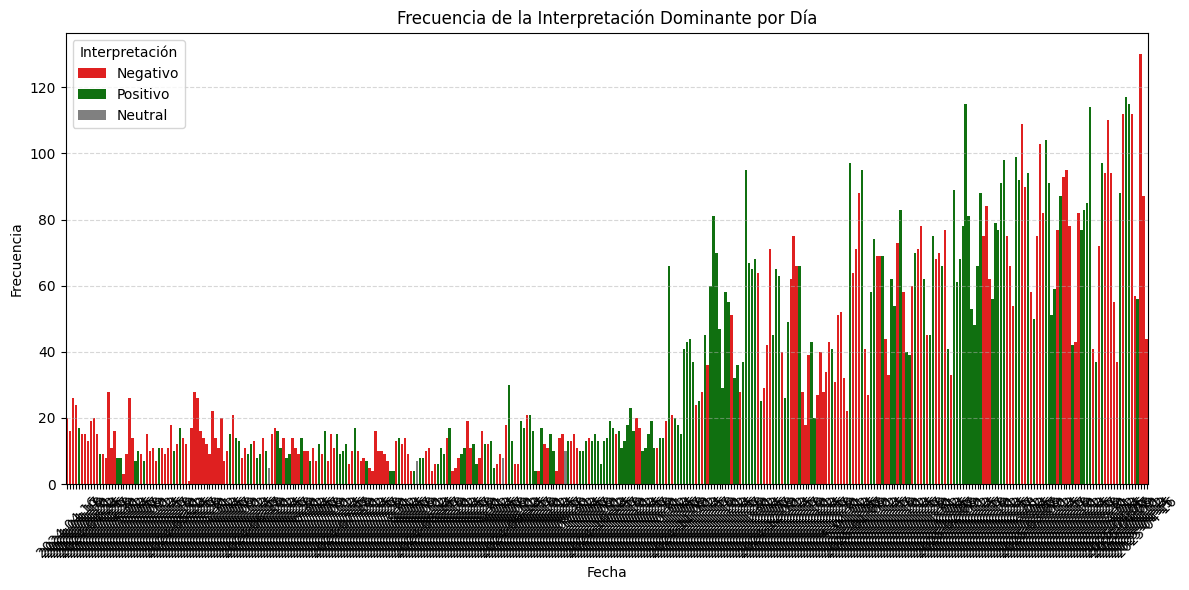

In [49]:
palette = {
    'Positivo': 'green',
    'Negativo': 'red',
    'Neutral': 'gray'
}

# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_filtrado,
    x='fecha',
    y='frecuencia',
    hue='interpretacion_moda',
    dodge=False,
    palette=palette
)

# Estética del gráfico
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de la Interpretación Dominante por Día')
plt.xticks(rotation=45)
plt.legend(title='Interpretación')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()